In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
from keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
print('Disease Classes:',len(os.listdir('/content/drive/MyDrive/Capstone-Project')))


Disease Classes: 13


In [4]:
train_data_dir = '/content/drive/MyDrive/Capstone-Project'


In [5]:
batch_size = 32
epochs = 50
img_height = 256
img_width = 256
color_channel = 3

In [6]:
#datagen = ImageDataGenerator(zoom_range=0.5,shear_range=0.3,rescale=1/255,horizontal_flip=True,)

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    shear_range=0.3,
    zoom_range=0.5,
    horizontal_flip=True,
    validation_split=0.2) # set validation split


In [7]:
train = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training') # set as training data

Found 12791 images belonging to 13 classes.


In [8]:
val = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation') # set as validation data

Found 3193 images belonging to 13 classes.


In [9]:
t_img, label = train.next()

In [10]:
t_img.shape

(32, 256, 256, 3)

In [11]:
def plot_image(img_arr,label):

  for im, l in zip (img_arr,label):

    plt.figure(figsize=(5,5))

    plt.imshow(im)

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


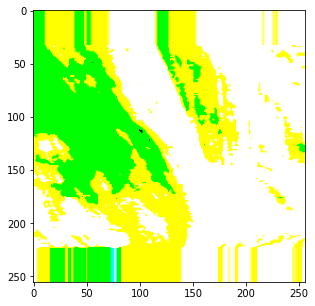

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


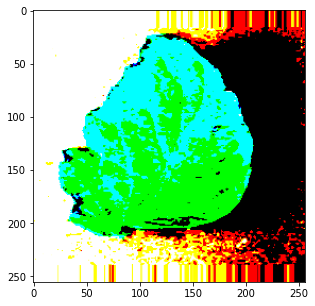

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


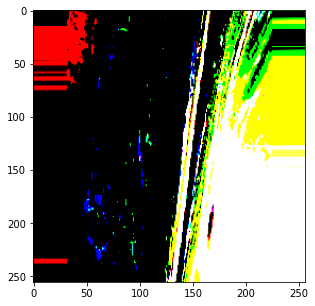

In [12]:
plot_image(t_img[:3],label[:3])

In [16]:
train.class_indices

{'Maize_Blight': 0,
 'Maize_Common_Rust': 1,
 'Maize_Gray_Leaf_Spot': 2,
 'Maize_Healthy': 3,
 'Tomato_Bacterial_spot': 4,
 'Tomato_Early_blight': 5,
 'Tomato_Late_blight': 6,
 'Tomato_Leaf_Mold': 7,
 'Tomato_Septoria_leaf_spot': 8,
 'Tomato_Spider_mites Two-spotted_spider_mite': 9,
 'Tomato_Target_Spot': 10,
 'Tomato_Tomato_Yellow_Leaf_Curl_Virus': 11,
 'Tomato_healthy': 12}

In [17]:
classes = len(train.class_indices)
classes

13

In [18]:
base_model = VGG19(input_shape=(img_width,img_height,color_channel),include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [19]:
for layer in base_model.layers:
  layer.trainable = False

In [20]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [21]:
X = Flatten()(base_model.output)

X = Dense(units=classes,activation='softmax')(X)

## creating model

model = Model(base_model.input,X)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [23]:
model.compile(optimizer='adam',loss= keras.losses.categorical_crossentropy,metrics='accuracy')

In [24]:
# # Early stopping and model check point



es = EarlyStopping(monitor='val_accuracy',
                   min_delta=0.01,
                   patience=3,
                   verbose=1)

mc = ModelCheckpoint(filepath='best_model.h5',
                     monitor='val_accuracy',
                     min_delta=0.01,
                     patience=3,
                     verbose=1,
                     save_best_only=True)

cb = [es,mc]

In [25]:
his = model.fit_generator(train,
                          validation_data=val,
                          epochs=epochs,
                          verbose=1,
                          callbacks=cb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 4.8560 - accuracy: 0.8131 
Epoch 1: val_accuracy improved from -inf to 0.82524, saving model to best_model.h5
400/400 [==============================] - 6626s 17s/step - loss: 4.8560 - accuracy: 0.8131 - val_loss: 5.4411 - val_accuracy: 0.8252
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 4.0194 - accuracy: 0.8827
Epoch 2: val_accuracy improved from 0.82524 to 0.88819, saving model to best_model.h5
400/400 [==============================] - 348s 871ms/step - loss: 4.0194 - accuracy: 0.8827 - val_loss: 4.5613 - val_accuracy: 0.8882
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 3.8957 - accuracy: 0.9038
Epoch 3: val_accuracy did not improve from 0.88819
400/400 [==============================] - 346s 865ms/step - loss: 3.8957 - accuracy: 0.9038 - val_loss: 4.7036 - val_accuracy: 0.8829
Epoch 4/50
400/400 [==============================] - ETA: 0s - loss: 3.3582 - accuracy

In [28]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

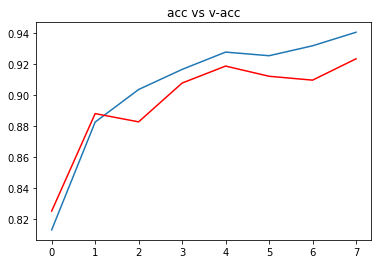

In [29]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c='red')
plt.title('acc vs v-acc')
plt.show()

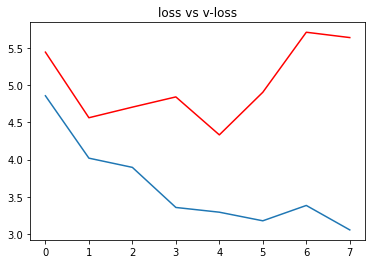

In [30]:
plt.plot(h['loss'])
plt.plot(h['val_loss'],c='red')
plt.title('loss vs v-loss')
plt.show()

In [ ]:
plant_diseases = {0: 'Maize_Blight', 1: 'Maize_Common_Rust',2:'Maize_Gray_Leaf_Spot',3:'Maize_Healthy',4:'Tomato_Bacterial_spot',
                  5:'Tomato_Early_blight',6:'Tomato_Late_blight',7:'Tomato_Leaf_Mold',8:'Tomato_Septoria_leaf_spot',
                  9:'Tomato_Spider_mites Two-spotted_spider_mite',10:'Tomato_Target_Spot',11:'Tomato_Tomato_Yellow_Leaf_Curl_Virus',12:'Tomato_healthy'}


import pickle
file_name='plant_diseases.pkl'
f = open(file_name,'wb')
pickle.dump(plant_diseases,f)
f.close()
